# AI analysis for forestry

Forestry wants the regional averages to be produced prior to the percentiles (etc.) being calculated rather than producing regional averages of the percentile maps (hopefully that makes sense!). The ask:

Produce regional averages of the AI for each region (shapefile with regions attached to this email) for each model for each GWL (1.2, 1.5, 2, 3)

Calculate the 10th, 50th, 90th percentiles of the AI from the multimodel ensemble for each region for each GWL (1.2, 1.5, 2, 3)

Plus:

Calculate the percent change in AI for GWL1.5, GWL2, GWL3 relative to GWL1.2 for each region for each model

Calculate the 10th, 50th, 90th percentiles from the multimodel ensemble of the ‘percent change’ values for each region for each GWL1.5, GWL2, GWL3

In [32]:
import geopandas as gpd
import sys
import xarray as xr
import numpy as np
import lib_david
import pandas as pd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import rasterio
import rasterio.features

# import needed packages
sys.path.append("/g/data/mn51/users/dh4185/repos_collab/plotting_maps")
from acs_area_statistics import get_regions, acs_regional_stats # this line has been updated 19 August 2024
regions = get_regions(["plantations"]) # this line has been updated 19 August 2024 #from acs_plotting_maps import plot_acs_hazard, regions_dict, cmap_dict, tick_dict
from acs_plotting_maps import plot_acs_hazard_3pp

# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

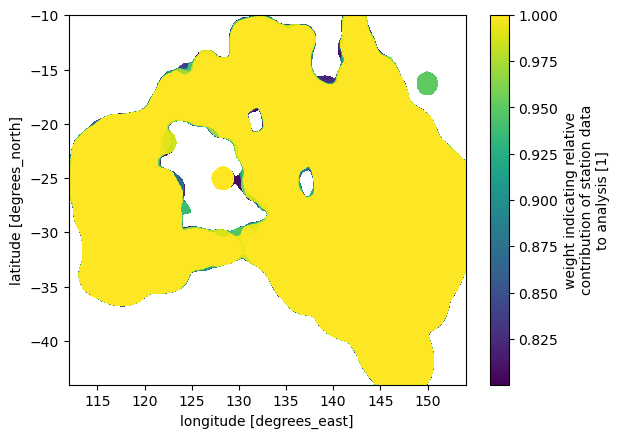

In [33]:
#< AGCD masking
mask_ds = xr.open_dataset("/g/data/mn51/users/dh4185/agcd_v1-0-2_precip_weight_r005_daily_1975_2005fraction_ge1.nc").sel(lat=slice(-44,-10),lon=slice(112,154))
q_mask = np.ma.masked_greater(mask_ds.fraction,0.8)
mask_ds.fraction.where(q_mask.mask).plot()

In [34]:
#< Directories
root_dir = "/g/data/ia39/ncra/drought_aridity/ai/"

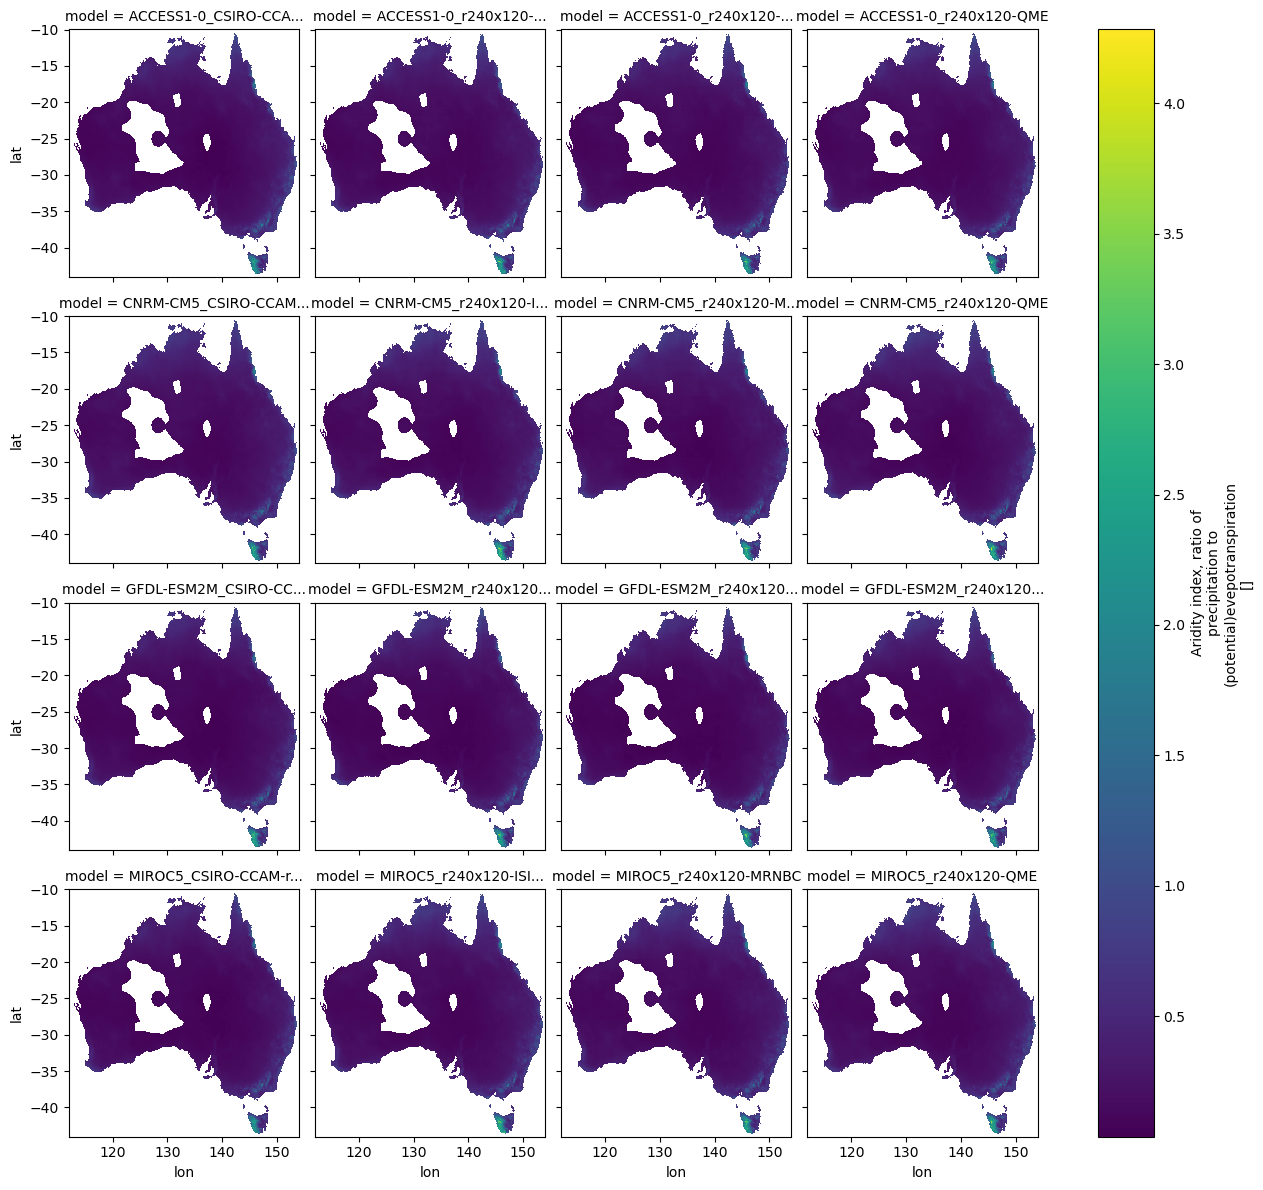

In [38]:
ds.AI.plot(col='model',col_wrap=4)

In [35]:
#< Read files for absolute values for each GWL for AI
gwl = ["GWL12"]#,"GWL15","GWL20","GWL30"]
root_dir = "/g/data/ia39/ncra/drought_aridity/ai/"
how = ["median"]
rcp = "rcp85"

list_all = []

for _gwl in gwl:
    list_model = []

    # for model in models:
    file = f'{root_dir}AI-atmospheric-based_NHP1-AUS-5_rcp85_bias-adjusted_2D_{_gwl}.nc'
    ds = xr.open_dataset(file).drop(['rcp','gwl']).where(q_mask.mask)
    
    mask_frac = regions.mask_3D_frac_approx(ds)
    da_summary = acs_regional_stats(ds=ds, 
                                mask = mask_frac, 
                                dims=("lat", "lon"),
                                how=how)#.to_dataframe()

In [36]:
da_summary.sel(model='ACCESS1-0_r240x120-QME').to_dataframe()#[da_summary['abbrevs']=='1']

,model,abbrevs,names,AI_median
region,,,,
0,ACCESS1-0_r240x120-QME,1,Western Australia (1),0.292909
1,ACCESS1-0_r240x120-QME,10,Southern Tablelands (10),0.526428
2,ACCESS1-0_r240x120-QME,11,Murray Valley (11),0.547931
3,ACCESS1-0_r240x120-QME,12,Central Victoria (12),0.478239
4,ACCESS1-0_r240x120-QME,13,Central Gippsland (13),0.650613
5,ACCESS1-0_r240x120-QME,14,East GippslandBombala (14),0.636365
6,ACCESS1-0_r240x120-QME,15,Tasmania (15),NaN
7,ACCESS1-0_r240x120-QME,2,Northern Territory (2),0.533745
8,ACCESS1-0_r240x120-QME,20,Pilliga (20),0.318415


### Using the shapefiles directly

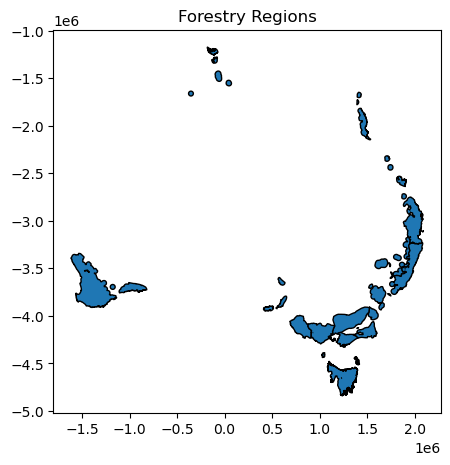

In [6]:
#< Read shapefile 
shp_file_dir = "/home/565/dh4185/mn51-dh4185/shapefiles/"

sf = gpd.read_file(f"{shp_file_dir}Plantations2016_buffered_NPI_and_Pilliga.shp", crs="epsg:4326")

# Plot the shapefile
sf.plot(edgecolor='black', figsize=(5, 5))
plt.title("Forestry Regions")
plt.show()

In [19]:
ds_masked = ds.where(q_mask.mask)
ds_masked.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
ds_masked.rio.write_crs("epsg:4326", inplace=True)

clipped = ds_masked.rio.clip(sf.geometry.apply(mapping), sf.crs, drop=True)

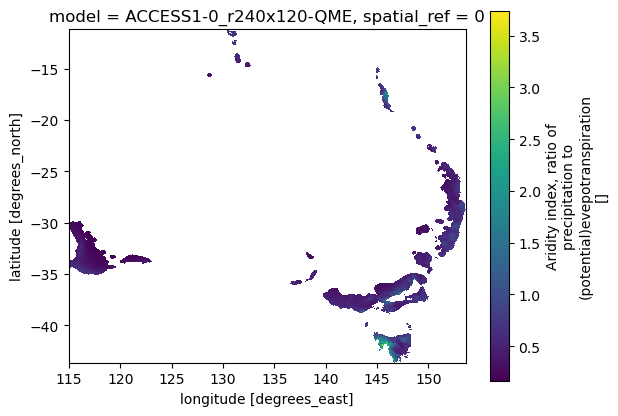

In [8]:
ax=sf.plot(facecolor='none',edgecolor='black')
pak=clipped.sel(model='ACCESS1-0_r240x120-QME').AI.plot(ax=ax,zorder=-1)
plt.show()#savefig('Pakistan.png',dpi=300)


In [48]:
da_masked = ds_masked.sel(model='ACCESS1-0_r240x120-QME').AI.squeeze()

# Make sure both the data and shapefile are in the same CRS
sf = sf.to_crs(da_masked.rio.crs)

clipped_data = da_masked.rio.clip(sf.geometry, sf.crs, drop=True)

# Ensure both `data` and `clipped_data` have the same dimensions along 'lat' and 'lon'
clipped_data = clipped_data.transpose('lat', 'lon')

# Rasterize the shapefile: create a mask where each geometry corresponds to a unique value
shapes = [(geom, idx) for idx, geom in enumerate(sf.geometry)]
rasterized = rasterio.features.rasterize(
    shapes,
    out_shape=(clipped_data.sizes['lat'], clipped_data.sizes['lon']),
    transform=clipped_data.rio.transform(),
    fill=np.nan,
    all_touched=True  # This ensures that all touched pixels are included
)

# Convert rasterized data into an xarray DataArray
regions_ = xr.DataArray(
    rasterized, 
    dims=['lat', 'lon'], 
    coords={'lat': clipped_data['lat'], 'lon': clipped_data['lon']},
    name="regions_"
)

# Ensure that `regions` and `clipped_data` have matching dimensions
assert regions_.shape == clipped_data.shape, "Shape mismatch between regions and clipped data"

# Calculate the mean for each region, ignoring NaN values
region_means = clipped_data.groupby(regions_).mean(dim=['lat', 'lon'], skipna=True)

# Add region names from shapefile as coordinates to the region_means DataArray
region_names = sf['Regn_Nm'].to_dict()  
region_means.coords['region_name'] = ('regions_', [region_names.get(int(region), 'Undefined') for region in region_means['regions_'].values])


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


In [53]:
region_means

<xarray.DataArray 'AI' (regions_: 18)> Size: 72B
array([1.0853413 , 0.3363403 , 0.43534598, 0.4657788 ,        inf,
       0.51597357, 0.6709863 , 0.48991162, 0.55111516, 0.5950067 ,
       0.51593536, 0.6687995 , 0.6311521 ,        inf, 0.5420466 ,
       0.94527006, 0.585145  , 0.31936744], dtype=float32)
Coordinates:
    model        <U45 180B 'ACCESS1-0_r240x120-QME'
    spatial_ref  int64 8B 0
  * regions_     (regions_) float64 144B 0.0 1.0 2.0 3.0 ... 14.0 15.0 16.0 17.0
    region_name  (regions_) <U38 3kB 'Tasmania' ... 'Pilliga'
Attributes:
    standard_name:    Aridity Index
    long_name:        Aridity index, ratio of precipitation to (potential)eve...
    units:            
    comment:          Using data on /g/data/wj02/COMPLIANT_PUBLISHED/
    cell_methods:     time: mean
    description:      Ratio of precipitation to (potential)evepotranspiration...
    method:           Using  atmospheric-based aridity: pr/e0
    history:          Tue Jun 18 22:04:29 2024: /g/data/hh5/public/apps/minic...
    bias correction:  method: r240x120-QME

In [25]:
clipped_data

<xarray.DataArray 'AI' (rcp: 1, gwl: 1, lat: 649, lon: 773)> Size: 2MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * lon          (lon) float64 6kB 115.0 115.0 115.1 115.2 ... 153.5 153.6 153.6
  * lat          (lat) float64 5kB -43.6 -43.55 -43.5 ... -11.3 -11.25 -11.2
    model        <U45 180B 'ACCESS1-0_r240x120-QME'
    spatial_ref  int64 8B 0
Dimensions without coordinates: rcp, gwl
Attributes:
    standard_name:    Aridity Index
    long_name:        Aridity index, ratio of precipitation to (potential)eve...
    units:            
    comment:          Using data on /g/data/wj02/COMPLIANT_PUBLISHED/
    cell_methods:     time: mean
    description:      Ratio of precipitation to (potential)evepotranspiration...
    method:           Using  atmospheric-based aridity: pr/e0
    history:          Tue Jun 18 22:04:29 2024: /g/data/hh5/public/apps/minic...
    bias correction:  method: r240x120-QME

In [ ]:
#< Compute regional mean for each model for each GWL (1.2, 1.5, 2, 3) -> output: 16 models, single value for each



In [8]:

#< Calculate 10th, 50th, 90th percentiles of the AI from the multimodel ensemble for each region for each GWL (1.2, 1.5, 2, 3)



## Using rio for cookie cutting